In [ ]:
!pip install -q predibase datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.4/362.4 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 55.6 

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from predibase import Predibase, FinetuningConfig, DeploymentConfig

# Get a KEY from https://app.predibase.com/
from google.colab import userdata
api_token: str = userdata.get('PREDIBASE_API_KEY')
pb = Predibase(api_token=api_token)

Connected to Predibase as User(id=b9caaef5-d76d-4bc6-8bc2-c2f4ad855d72, username=tsankhya@lakeheadu.ca)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ruslanmv/ai-medical-chatbot")

# Inspect the dataset
print(dataset)
# Replace 'split_name' with an actual split, e.g., 'train'
print(dataset['train'].features)

DatasetDict({
    train: Dataset({
        features: ['Description', 'Patient', 'Doctor'],
        num_rows: 256916
    })
})
{'Description': Value(dtype='string', id=None), 'Patient': Value(dtype='string', id=None), 'Doctor': Value(dtype='string', id=None)}


In [ ]:
import csv

def hfdataset_to_csv(datalist: list, csv_file_name, max=-1):
  template = {
    "prompt": """system\nThe following is a medical query from a patient. Please analyze and generate a detailed response.\npatient_query\n{Patient}\ndetailed_answer\n""",
    "completion": "{Doctor}",  # The completion should include the doctor's response
    "split": "train"  # Use "all" or another relevant label since your dataset is not split
}



  with open(csv_file_name, 'w', newline='') as csvfile:
    fieldnames = template.keys()
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i, d in enumerate(datalist):
      if i >= max:
        break

      row = {
          "prompt": template["prompt"].format(Patient=d["Patient"]),  # Only the patient content is included in the prompt
          "completion": template["completion"].format(Doctor=d["Doctor"]),  # The completion now includes the doctor's response
          "split": "train"  # Use "all" or similar placeholder
            }
      writer.writerow(row)


In [ ]:
def validate_data_csv(csv_file_name):
  """ Make sure it has prompt, completion, and split with all values """
  with open(csv_file_name, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
      assert row['prompt']
      assert row['completion']
      assert row['split']

  return True

In [ ]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_pretrained("upstage/solar-1-mini-tokenizer")

def compute_cost(csv_file_name, price_per_million_tokens=0.5):
  """ Compute the cost of the dataset """

  total_num_of_tokens = 0
  with open(csv_file_name, 'r') as f:
    reader = csv.DictReader(f)
    # get all values
    values = [row['completion']+ " " + row['prompt'] for row in reader]
    for value in values:
      # tokenize
      enc = tokenizer.encode(value)
      num_of_tokens = len(enc.tokens)
      total_num_of_tokens += num_of_tokens


  return total_num_of_tokens / 1000000 * price_per_million_tokens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/GitHub/MedAI

/content/drive/My Drive/GitHub/MedAI


In [ ]:
import time

hfdataset = load_dataset("ruslanmv/ai-medical-chatbot", trust_remote_code=True)
train_hfdataset = hfdataset["train"]
test_hfdataset = hfdataset["test"]

dataset_name = "solar-ai-medical-chatbot"
csv_file_name = f"{dataset_name}.csv"
try:
  pb_dataset = pb.datasets.get(dataset_name)
  print(f"Dataset found: {pb_dataset}")
except RuntimeError:
  print("Dataset not found, creating...")

  hfdataset_to_csv(train_hfdataset, csv_file_name, max=300)

  print(f"Dataset Validation: {validate_data_csv(csv_file_name)}")
  print(f"One step FT Cost: {compute_cost(csv_file_name)} USD")

  print("Uploading daatset...")
  pb_dataset = pb.datasets.from_file(csv_file_name, name=dataset_name)


In [ ]:
from datasets import load_dataset

# Load your dataset
hfdataset = load_dataset("ruslanmv/ai-medical-chatbot", trust_remote_code=True)

# If the dataset is not split, it will typically be loaded as a single set (e.g., "train")
unsplit_dataset = hfdataset["train"]  # Load the full dataset

# Split the dataset into training and test sets
split_dataset = unsplit_dataset.train_test_split(test_size=0.3)  # Adjust the test_size as needed

# Access the splits
train_hfdataset = split_dataset["train"]
test_hfdataset = split_dataset["test"]

# Now you can proceed with your original code
dataset_name = "ai-medical-chatbot"
csv_file_name = f"{dataset_name}.csv"

try:
    pb_dataset = pb.datasets.get(dataset_name)
    print(f"Dataset found: {pb_dataset}")
except RuntimeError:
    print("Dataset not found, creating...")

    # Save the training data to CSV
    hfdataset_to_csv(train_hfdataset, csv_file_name, max=300)  # Adjust max as needed

    print(f"Dataset Validation: {validate_data_csv(csv_file_name)}")
    print(f"One step FT Cost: {compute_cost(csv_file_name)} USD")

    print("Uploading dataset...")
    pb_dataset = pb.datasets.from_file(csv_file_name, name=dataset_name)

# If needed, you can repeat the process for the test set as well


Dataset not found, creating...
Dataset Validation: True
One step FT Cost: 0.0412495 USD
Uploading dataset...


In [ ]:
# Create an adapter repository
repo_name = "Solar_Med_AI"
repo = pb.repos.create(name=repo_name, description="AI Consultation", exists_ok=True)
print(repo)

uuid='c1fa2e6d-3270-4897-b103-c6b838adecca' name='Solar_Med_AI' description='AI Consultation'


In [ ]:

# we are creating an adapter here
# Start a fine-tuning job, blocks until training is finished
adapter = pb.adapters.create(
    config=FinetuningConfig(
        base_model="solar-1-mini-chat-240612",
        epochs=1, # default: 3
        rank=1, # default: 16
    ),
    dataset=pb_dataset, # Also accepts the dataset name as a string
    repo=repo,
    description="initial model with defaults"
)

Successfully requested finetuning of solar-1-mini-chat-240612 as `Solar_Med_AI/1`. (Job UUID: 96c26905-1b0e-4a93-bdb4-1daa8c812228).

Watching progress of finetuning job 96c26905-1b0e-4a93-bdb4-1daa8c812228. This call will block until the job has finished. Canceling or terminating this call will NOT cancel or terminate the job itself.

Job is starting. Total queue time: 0:00:46         
Waiting to receive training metrics...

┌────────────┬────────────┬─────────────────┐
│ checkpoint │ train_loss │ validation_loss │
├────────────┼────────────┼─────────────────┤
│     1      │   2.5687   │        --       │
└────────────┴────────────┴─────────────────┘


In [ ]:
adapter

Adapter(repo='Solar_Med_AI', tag=1, archived=False, base_model='solar-1-mini-chat-240612', description='initial model with defaults', artifact_path='96c26905-1b0e-4a93-bdb4-1daa8c812228/e90b08fb18e142f8b7e6c76bcbcbbd3c/artifacts/model/model_weights', finetuning_error=None, finetuning_job_uuid='96c26905-1b0e-4a93-bdb4-1daa8c812228')

In [ ]:
adapter_id = adapter.repo + "/" + str(adapter.tag)
adapter_id

'Solar_Med_AI/1'

In [ ]:
input_prompt = """
system\nThe following text is a medical query from a patient. Please provide a detailed answer based on the doctor's response.
patient_query\nI am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?
detailed_answer
"""


In [ ]:
lorax_client = pb.deployments.client("solar-1-mini-chat-240612")
print(lorax_client.generate(input_prompt, adapter_id=adapter_id, max_new_tokens=1000).generated_text)

Abutting and abutment of the nerve root refers to the compression or impingement of a nerve root by surrounding structures, such as bone or soft tissue. This can occur in the spine, where the nerve roots exit the spinal cord through the spinal canal. The term "annular bulging and tear" refers to a condition where the outer ring of the intervertebral disc (the annulus) bulges or tears, potentially causing pressure on the nearby nerve roots or the spinal cord.

Treatment for annular bulging and tear typically involves a combination of conservative measures and, in some cases, surgical intervention. Conservative treatments may include:

1. Physical therapy: To help improve strength, flexibility, and posture.
2. Pain management: Using medications, such as nonsteroidal anti-inflammatory drugs (NSAIDs) or muscle relaxants, to manage pain and inflammation.
3. Injections: Such as corticosteroid injections, which can help reduce inflammation and pain.
4. Lifestyle modifications: Including maint

In [ ]:
#Curl Test
import requests
import json

url = "*******Insert your unique URL here*******"
#Should look like this https://serving.app.predibase.com/[Tenant ID]/deployments/v2/llms/solar-1-mini-chat-240612/generate



payload = {
    "inputs": input_prompt,
    "parameters": {
        "adapter_id": adapter_id,
        "adapter_source": "pbase",
        "max_new_tokens": 500,
        "temperature": 0.1
    }
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_token}"
}

response = requests.post(url, data=json.dumps(payload), headers=headers)

print(response.text)

{"generated_text":"Abutting and abutment of the nerve root refers to the pressure or impingement on the nerve root due to the proximity of the nerve root to other structures in the spine. This can cause pain, numbness, and weakness in the affected area.\n\nTreatment for annular bulging and tear typically involves conservative management such as physical therapy, pain management, and lifestyle modifications. In some cases, surgery may be necessary if the symptoms are severe or if there is significant nerve compression."}


In [ ]:
# Download adapter
pb.adapters.download(adapter_id, dest=f"{adapter.tag}.zip")

Done!


In [ ]:
# model Evaluation

In [ ]:
!pip -q install langchain langchain-upstage solar-as-judge

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.0 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
import solar_as_judge as saj

os.environ["UPSTAGE_API_KEY"] = userdata.get('UPSTAGE_API_KEY')

prompt = "Please extract important keyword from this text: I love you so much"
ground_truth = "love"
A_answer = "love"
B_answer = "so much"

a_score, b_score = saj.judge(prompt, A_answer, B_answer, ground_truth)
print(a_score, b_score)


10 2


In [ ]:
# Create test dataset
test_csv_file_name = f"test_dataset.csv"
hfdataset_to_csv(test_hfdataset, test_csv_file_name, max=20)

win_results = {"A_wins":0, "B_wins": 0, "tie": 0,  "A_score": 0, "B_score": 0}
with open(test_csv_file_name, 'r') as f:
  reader = csv.DictReader(f)
  for row in reader:
    prompt = row['prompt']
    ground_truth = row['completion']
    A_answer = lorax_client.generate(prompt, max_new_tokens=1000).generated_text
    B_answer = lorax_client.generate(prompt, adapter_id=adapter_id, max_new_tokens=1000).generated_text

    A_score, B_score = saj.judge(prompt, A_answer, B_answer, ground_truth)
    print( A_score, B_score, A_answer, B_answer)
    win_results["A_score"] += A_score
    win_results["B_score"] += B_score
    if A_score > B_score:
      win_results["A_wins"] += 1
    elif B_score > A_score:
      win_results["B_wins"] += 1
    else:
      win_results["tie"] += 1
    print(win_results)


0 0 The renal ultrasound report indicates that you have mild hydronephrosis in your right kidney, which means there is a mild dilation of the kidney's pelvis and ureter. Additionally, your right kidney has mild cortical thinning and increased cortical echogenicity, which can be associated with renal failure, both chronic and acute. The left kidney also has mildly increased cortical echogenicity, but there is no hydronephrosis in the left kidney. The urinary bladder appears normal.

It is essential to discuss these findings with your healthcare provider to determine the next steps in your care. They may recommend further testing or treatments depending on your overall health and medical history. The renal ultrasound report indicates that you have mild hydronephrosis in your right kidney, which means there is a mild dilation of the kidney's pelvis and ureter. Additionally, your right kidney has mild cortical thinning and increased cortical echogenicity, which can be associated with renal

In [ ]:
print(win_results)

{'A_wins': 5, 'B_wins': 1, 'tie': 14, 'A_score': 51, 'B_score': 43}


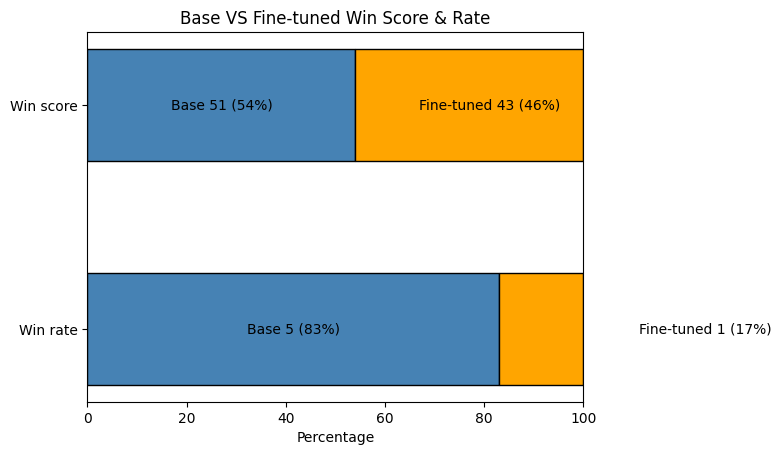

In [ ]:
# Sample data similar to the image
categories = ["Win rate", "Win score"]
win_rate_sum = win_results["A_wins"] + win_results["B_wins"]
win_score_sum = win_results["A_score"] + win_results["B_score"]

percentages1 = [round(win_results["A_wins"]*100/win_rate_sum), round(win_results["A_score"]*100/win_score_sum)]
percentages2 = [round(win_results["B_wins"]*100/win_rate_sum), round(win_results["B_score"]*100/win_score_sum)]
values1 = [win_results["A_wins"], win_results["A_score"]]
values2 = [win_results["B_wins"], win_results["B_score"]]

# Create a bar plot

# Bar positions
bar_width = 0.5
y_pos = range(len(categories))

# Plotting the bars
fig, ax = plt.subplots()

ax.barh(y_pos, percentages1, color='steelblue', edgecolor='black', height=bar_width)
ax.barh(y_pos, percentages2, left=percentages1, color='orange', edgecolor='black', height=bar_width)

# Adding text
for i in range(len(categories)):
    ax.text(percentages1[i]/2, i, f"Base {values1[i]} ({percentages1[i]}%)", ha='center', va='center', color='black')
    ax.text(percentages1[i] + percentages1[i]/2, i, f"Fine-tuned {values2[i]} ({percentages2[i]}%)", ha='center', va='center', color='black')

# Labels and Titles
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage')
ax.set_title('Base VS Fine-tuned Win Score & Rate')

plt.show()


In [ ]:
# Create test dataset
test_csv_file_name = f"test_dataset.csv"
hfdataset_to_csv(test_hfdataset, test_csv_file_name, max=100)

win_results = {"A_wins":0, "B_wins": 0, "tie": 0,  "A_score": 0, "B_score": 0}
with open(test_csv_file_name, 'r') as f:
  reader = csv.DictReader(f)
  for row in reader:
    prompt = row['prompt']
    ground_truth = row['completion']
    A_answer = lorax_client.generate(prompt, max_new_tokens=1000).generated_text
    B_answer = lorax_client.generate(prompt, adapter_id=adapter_id, max_new_tokens=1000).generated_text

    A_score, B_score = saj.judge(prompt, A_answer, B_answer, ground_truth)
    print( A_score, B_score, A_answer, B_answer)
    win_results["A_score"] += A_score
    win_results["B_score"] += B_score
    if A_score > B_score:
      win_results["A_wins"] += 1
    elif B_score > A_score:
      win_results["B_wins"] += 1
    else:
      win_results["tie"] += 1
    print(win_results)


6 8 The renal ultrasound report indicates that you have mild hydronephrosis in your right kidney, which means there is a mild dilation of the kidney's pelvis and ureter. Additionally, your right kidney has mild cortical thinning and increased cortical echogenicity, which can be associated with renal failure, both chronic and acute. The left kidney also has mildly increased cortical echogenicity, but there is no hydronephrosis in the left kidney. The urinary bladder appears normal.

It is essential to discuss these findings with your healthcare provider to determine the next steps in your care. They may recommend further testing or treatments depending on your overall health and medical history. The renal ultrasound report indicates that you have mild hydronephrosis in your right kidney, which means there is a mild dilation of the kidney's pelvis and ureter. Additionally, your right kidney has mild cortical thinning and increased cortical echogenicity, which can be associated with renal

In [ ]:
print(win_results)

{'A_wins': 36, 'B_wins': 10, 'tie': 54, 'A_score': 382, 'B_score': 328}


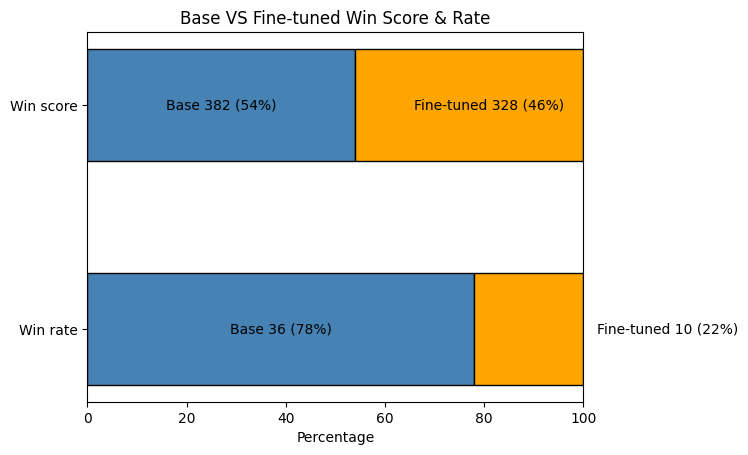

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data similar to the image
categories = ["Win rate", "Win score"]
win_rate_sum = win_results["A_wins"] + win_results["B_wins"]
win_score_sum = win_results["A_score"] + win_results["B_score"]

percentages1 = [round(win_results["A_wins"]*100/win_rate_sum), round(win_results["A_score"]*100/win_score_sum)]
percentages2 = [round(win_results["B_wins"]*100/win_rate_sum), round(win_results["B_score"]*100/win_score_sum)]
values1 = [win_results["A_wins"], win_results["A_score"]]
values2 = [win_results["B_wins"], win_results["B_score"]]

# Create a bar plot

# Bar positions
bar_width = 0.5
y_pos = range(len(categories))

# Plotting the bars
fig, ax = plt.subplots()

ax.barh(y_pos, percentages1, color='steelblue', edgecolor='black', height=bar_width)
ax.barh(y_pos, percentages2, left=percentages1, color='orange', edgecolor='black', height=bar_width)

# Adding text
for i in range(len(categories)):
    ax.text(percentages1[i]/2, i, f"Base {values1[i]} ({percentages1[i]}%)", ha='center', va='center', color='black')
    ax.text(percentages1[i] + percentages1[i]/2, i, f"Fine-tuned {values2[i]} ({percentages2[i]}%)", ha='center', va='center', color='black')

# Labels and Titles
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage')
ax.set_title('Base VS Fine-tuned Win Score & Rate')

plt.show()
